In [1]:
import importlib
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import swifter  # noqa: F401

from stk_search.geom3d import train_models
from stk_search.ObjectiveFunctions.ObjectiveFunction import LookUpTable
from stk_search.Representation import (
    Representation_from_fragment,
)
from stk_search.Search_algorithm import (
    BayesianOptimisation,
    Ea_surrogate,
    Search_algorithm,
)

Path("search_experiment/search_exp_database").mkdir(
    parents=True, exist_ok=True
)


In [2]:
# load Search space and check conditions

SearchSpace_loc = "SearchSpace/SearchSpace_test.pkl"

with Path(SearchSpace_loc).open("rb") as f:
    sp = pickle.load(f)  # noqa: , S301,
sp.update()
print(sp.syntax)
print(sp.conditions_list)
print(f"size of the search space is : {sp.get_space_size():.2e}")
sp.df_precursors.head()

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]
size of the search space is : 9.40e+14


,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au)_x,HOMO-LUMO GAP (eV),total energy (au)_y,InChIKey,mol_opt,Atom_num
0,3.0685,0.095166,9.1140,-56.555859,1.672081,-56.265024,GVYASUPVXDSGHN-UQCOIBPSSA-N,<rdkit.Chem.rdchem.Mol object at 0x714525e99c70>,22
1,2.8466,0.038435,9.3325,-56.536670,2.258122,-56.253990,HNRHIGPDSSXEJA-FARCUNLSSA-N,<rdkit.Chem.rdchem.Mol object at 0x714525e99c20>,22
2,2.9365,0.072094,9.2252,-56.533763,2.009171,-56.247781,SNMJIXVGAOBXCS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x714525e99cc0>,22
3,2.5901,0.064465,8.9842,-48.098467,2.153852,-47.825214,LWMBLJLODRWDDF-NYYWCZLTSA-N,<rdkit.Chem.rdchem.Mol object at 0x714525e99d10>,22
4,2.5596,0.076792,8.8405,-48.091982,1.967541,-47.819849,BJFIUKSBVAJFOJ-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x714525e99d60>,22


In [3]:
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path)
oligomer_size = 6
target_name = "target"
aim = "maximise"
df_total["target"] = (
    -np.abs(df_total["ES1"] - 3)
    - np.abs(df_total["ionisation potential (eV)"] - 5.5)
    + np.log10(df_total["fosc1"])
)
df_total.to_csv(df_total_path, index=False)
# define the evaluation function
ObjectiveFunction = LookUpTable(
    df_total, oligomer_size, target_name=target_name, aim=aim
)

In [4]:
# test evaluation function
molecule_id = 0
molecule_properties = sp.check_df_for_element_from_sp(df_total).iloc[
    [molecule_id]
]
print(molecule_properties["InChIKey"])
molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
ObjectiveFunction.evaluate_element(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)

0    CLUOOVKTWZALSH-UHFFFAOYSA-N
Name: InChIKey, dtype: object


(-2.5070288713583553, 'CLUOOVKTWZALSH-UHFFFAOYSA-N')

In [5]:
# initialise search algorithm

which_acquisition = "EI"
lim_counter = 10
BO_learned = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)
EA = Search_algorithm.evolution_algorithm()
SUEA = Ea_surrogate.Ea_surrogate()
BO_Mord = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)

In [6]:
# load the Representation and the model

config_dir = "data_example/representation_learning/splitrand-nummol20000/"
config, min_val_loss = train_models.get_best_embedding_model(config_dir)

SUEA = Ea_surrogate.Ea_surrogate()
SUEA.config_dir = config_dir
SUEA.load_representation_model()
BO_learned.config_dir = config_dir
BO_learned.load_representation_model()


Model loaded:  SchNet
Model loaded:  SchNet


(<stk_search.Representation.Representation_poly_3d.RepresentationPoly3d at 0x714518d004f0>,
 Pymodel_new(
   (molecule_3D_repr): SchNet(hidden_channels=128, num_filters=128, num_interactions=8, num_gaussians=51, cutoff=6)
   (graph_pred_linear): Linear(in_features=128, out_features=1, bias=True)
   (transform_to_opt): Linear(in_features=128, out_features=128, bias=True)
 ))

In [7]:
# initialise the Representation of the molecules used
# here we use the dataframe of the precursors that has PCA of desrciprtors calculated using mordred

df_representation_path = "data_example/precursor/df_mordred_24072024.pkl"
df_representation = pd.read_pickle(df_representation_path)  # noqa: S301
df_representation = df_representation.dropna(axis=1)
# check if the Representation dataframe contains all the elements in teh search space
print(
    "number of element not in the Representation dataframe ",
    -(
        sp.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum()
        - sp.df_precursors.shape[0]
    ),
)
if (
    -(
        sp.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum()
        - sp.df_precursors.shape[0]
    )
    > 0
):
    sp.df_precursors = sp.df_precursors[
        sp.df_precursors["InChIKey"].isin(df_representation["InChIKey"])
    ]
    with Path(SearchSpace_loc).open("wb") as f:
        pickle.dump(sp, f)
frag_properties = df_representation.select_dtypes(include=[np.number]).columns
print(frag_properties)
BO_Mord.Representation = (
    Representation_from_fragment.RepresentationFromFragment(
        df_representation, frag_properties
    )
)


number of element not in the Representation dataframe  0
Index(['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9'],
      dtype='object')


In [8]:
# test representation

molecule_id = 0
molecule_properties = sp.check_df_for_element_from_sp(df_total).iloc[
    [molecule_id]
]
print(molecule_properties["InChIKey"])
X_rpr = SUEA.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print(X_rpr)
X_rpr = BO_learned.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)
print(X_rpr)

BO_Mord.Representation.generate_repr(
    molecule_properties[[f"InChIKey_{x}" for x in range(oligomer_size)]]
)

0    CLUOOVKTWZALSH-UHFFFAOYSA-N
Name: InChIKey, dtype: object
tensor([[ 0.1417,  0.3532,  0.6085,  0.0272,  0.1343,  0.3805, -0.0399, -0.3059,
          0.2316,  0.0622, -0.2203, -0.3029, -0.1769,  0.1601, -0.3236,  0.1478,
         -0.2510, -0.0188, -0.4512, -0.1417,  0.0479,  0.2816,  0.3486,  0.1556,
          0.1332,  0.2660, -0.3931, -0.4436,  0.2244, -0.3033,  0.1446, -0.4518,
          0.0987,  0.2211, -0.1881,  0.2777,  0.1778,  0.1911, -0.1662,  0.1010,
          0.3406, -0.0163,  0.4243, -0.0293,  0.5388, -0.2400, -0.0238, -0.1496,
          0.0362,  0.3610, -0.1622, -0.0590, -0.0347, -0.0454, -0.0376, -0.1943,
         -0.3544, -0.2063, -0.4570,  0.5313, -0.3119,  0.4948, -0.3478,  0.0188,
          0.0007,  0.4584, -0.1681,  0.0902, -0.2440,  0.3692,  0.4220, -0.0227,
         -0.0476,  0.2752, -0.2138, -0.2509,  0.0231, -0.1412, -0.0031,  0.1457,
         -0.0611, -0.0174, -0.6084,  0.1283,  0.3202,  0.0045,  0.2109,  0.0135,
          0.2852,  0.2423, -0.0271,  0.2797, -

tensor([[-20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503,
         -20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503,
         -20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503,
         -20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503,
         -20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503,
         -20866.4727,  -2118.6951,   -912.7706,  -3974.8157,   4410.3105,
           -453.4961,    547.4171,    273.9087,   2319.2112,  -1551.6503]])

In [9]:
from stk_search import SearchExp

importlib.reload(SearchExp)


# set experiment conditions
def define_and_run_search(
    search_algorithm=EA,
    num_elem_initialisation=50,
    number_of_iterations=100,
    verbose=True,
    case_name="test",
):
    """Define and run a search experiment.

    Args:
    ----
        search_algorithm (Search_algorithm): The search algorithm to use.
        num_elem_initialisation (int): The number of elements to initialise.
        number_of_iterations (int): The number of iterations to run the search for.
        verbose (bool): Whether to print the search progress.
        case_name (str): The name of the search experiment.

    Returns:
    -------
        int: The maximum id acquired.

    """
    s_exp = SearchExp.SearchExp(
        sp,
        search_algorithm,
        ObjectiveFunction,
        number_of_iterations,
        verbose=verbose,
    )
    benchmark = True
    s_exp.output_folder = (
        f"output/search_experiment/{oligomer_size}_frag/" + case_name
    )
    s_exp.num_elem_initialisation = num_elem_initialisation
    s_exp.benchmark = benchmark
    s_exp.df_total = df_total
    # Save search inputs
    import json
    import subprocess

    def save_run_search_inputs(
        inputs, save_path="run_search_new_inputs.json"
    ) -> int:
        """Save the inputs to a file.

        Args:
        ----
            inputs (dict): The inputs to save.
            save_path (str): The path to save the inputs to.

        """
        # Get the current git version
        git_version = (
            subprocess.check_output(["git", "rev-parse", "HEAD"])
            .strip()
            .decode("utf-8")
        )

        # Add the git version to the inputs
        inputs["git_version"] = git_version

        # Save the inputs to a file
        with Path(save_path).open("w") as f:
            json.dump(inputs, f)

        print("Inputs saved.")
        return 0

    input_json = {}
    input_json["SearchSpace_loc"] = SearchSpace_loc
    input_json["search_algorithm"] = search_algorithm.name
    input_json["ObjectiveFunction"] = ObjectiveFunction.__str__()
    input_json["number_of_iterations"] = number_of_iterations
    input_json["verbose"] = verbose
    input_json["num_elem_initialisation"] = num_elem_initialisation
    input_json["benchmark"] = benchmark
    input_json["df_total"] = df_total_path
    input_json["df_representation"] = df_representation_path
    if "Representation" in search_algorithm.__dict__:
        input_json["representation"] = search_algorithm.Representation.name
    else:
        input_json["representation"] = None
    input_json["frag_properties"] = list(frag_properties)
    input_json["which_acquisition"] = which_acquisition
    input_json["run_search_name"] = s_exp.search_exp_name
    input_json["search_output_folder"] = s_exp.output_folder
    input_json["date"] = s_exp.date
    input_json["oligomer_size"] = oligomer_size
    input_json["config_dir"] = config_dir
    input_json["case_name"] = case_name
    save_path = f"output/search_experiment/search_exp_database/{s_exp.search_exp_name}.json"
    Path("output/search_experiment/search_exp_database").mkdir(
        parents=True, exist_ok=True
    )

    save_run_search_inputs(input_json, save_path)
    s_exp.run_seach()
    return max(s_exp.ids_acquired)

In [10]:
for _ in range(5):
    define_and_run_search(search_algorithm=BO_Mord, case_name="BO_Mord", num_elem_initialisation=50)

Inputs saved.


KeyboardInterrupt: 

In [ ]:
for _ in range(10):
    s_exp = define_and_run_search(search_algorithm=EA, case_name="EA")


Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.


In [ ]:
for _ in range(10):
    define_and_run_search(search_algorithm=SUEA, case_name="SUEA")

Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.


In [ ]:
for _ in range(5):
    define_and_run_search(search_algorithm=BO_learned, case_name="BO_learned")

Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.


# load results and plot some metrics

In [11]:
import json
import pickle


def load_search_list(df):
    """Load the search list from the dataframe."""
    search_list = []
    for _index, row in df.iterrows():
        with Path(row["search_exp_file"]).open("rb") as f:
            search_list.append(pickle.load(f))
    return search_list


save_path = "output/search_experiment/search_exp_database"
json_files = list(Path(f"{save_path}/").glob("*.json"))
list_json = []
for json_file in json_files:
    try:
        with Path(json_file).open("r") as f:
            list_json.append(json.load(f))
        f.close()
    except FileExistsError:
        print("error oppening", json_file)
df = pd.DataFrame(list_json)
df["search_exp_file"] = (
    df["search_output_folder"]
    + "/"
    + df["date"]
    + "/results_"
    + df["run_search_name"]
    + ".pkl"
)
print(df.shape)
df_all = df.copy()
df_all.head()


(192, 22)


,SearchSpace_loc,search_algorithm,ObjectiveFunction,number_of_iterations,verbose,num_elem_initialisation,benchmark,df_total,df_representation,representation,...,run_search_name,search_output_folder,date,oligomer_size,config_dir,case_name,git_version,search_space_loc,objective_function,search_exp_file
0,SearchSpace/SearchSpace_test.pkl,Surrogate_EA,<stk_search.ObjectiveFunction.LookUpTable obje...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,RepresentationPoly3d,...,3121e7c8a3614aba8c95f5f2dd6d573d,output/search_experiment/6_frag/SUEA,20240829,6,data_example/representation_learning/splitrand...,SUEA,c86260325e92a97eaa9994a1bf62b284c9c6cd2f,NaN,NaN,output/search_experiment/6_frag/SUEA/20240829/...
1,SearchSpace/SearchSpace_test.pkl,Surrogate_EA,<stk_search.ObjectiveFunction.LookUpTable obje...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,RepresentationPoly3d,...,919751cb21f640b98ac34c8f0b6bf291,output/search_experiment/6_frag/SUEA,20240829,6,data_example/representation_learning/splitrand...,SUEA,c86260325e92a97eaa9994a1bf62b284c9c6cd2f,NaN,NaN,output/search_experiment/6_frag/SUEA/20240829/...
2,SearchSpace/SearchSpace_test.pkl,Surrogate_EA,<stk_search.ObjectiveFunction.LookUpTable obje...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,RepresentationPoly3d,...,f05db3ea26664c96a242f7b9992ea460,output/search_experiment/6_frag/SUEA,20240829,6,data_example/representation_learning/splitrand...,SUEA,c86260325e92a97eaa9994a1bf62b284c9c6cd2f,NaN,NaN,output/search_experiment/6_frag/SUEA/20240829/...
3,SearchSpace/SearchSpace_test.pkl,Evolution_algorithm,<stk_search.ObjectiveFunction.LookUpTable obje...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,None,...,dfb131f87c8941559fb97c4c6c5e70a4,output/search_experiment/6_frag/EA,20240829,6,data_example/representation_learning/splitrand...,EA,c86260325e92a97eaa9994a1bf62b284c9c6cd2f,NaN,NaN,output/search_experiment/6_frag/EA/20240829/re...
4,SearchSpace/SearchSpace_test.pkl,Evolution_algorithm,<stk_search.ObjectiveFunction.LookUpTable obje...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,None,...,33c92e5fc65e41279670e125a47508be,output/search_experiment/6_frag/EA,20240829,6,data_example/representation_learning/splitrand...,EA,c86260325e92a97eaa9994a1bf62b284c9c6cd2f,NaN,NaN,output/search_experiment/6_frag/EA/20240829/re...


In [12]:
num_iteration = 20
num_elem_initialisation = 50
oligomer_size = 6
df_filtered = df_all[df_all["oligomer_size"] == oligomer_size]
print(df_filtered.shape)
df_list = df_filtered.groupby(
    ["which_acquisition", "config_dir", "search_algorithm", "case_name"]
)
print(len(df_list))
df_list.describe()

(192, 22)
4


number_of_iterations  \
                                                                                                                     count   
which_acquisition config_dir                                         search_algorithm      case_name                         
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord                    22.0   
                                                                                           BO_learned                 17.0   
                                                                     Evolution_algorithm   EA                        109.0   
                                                                     Surrogate_EA          SUEA                       44.0   

                                                                                                              \
                                                                                                        mean   
which_acquisition config_dir                                         search_algorithm      case_name           
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     100.0   
                                                                                           BO_learned  100.0   
                                                                     Evolution_algorithm   EA          100.0   
                                                                     Surrogate_EA          SUEA        100.0   

                                                                                                            \
                                                                                                       std   
which_acquisition config_dir                                         search_algorithm      case_name         
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     0.0   
                                                                                           BO_learned  0.0   
                                                                     Evolution_algorithm   EA          0.0   
                                                                     Surrogate_EA          SUEA        0.0   

                                                                                                              \
                                                                                                         min   
which_acquisition config_dir                                         search_algorithm      case_name           
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     100.0   
                                                                                           BO_learned  100.0   
                                                                     Evolution_algorithm   EA          100.0   
                                                                     Surrogate_EA          SUEA        100.0   

                                                                                                              \
                                                                                                         25%   
which_acquisition config_dir                                         search_algorithm      case_name           
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     100.0   
                                                                                           BO_learned  100.0   
                                                                     Evolution_algorithm   EA          100.0   
                                                                     Surrogate_EA          SUEA        100.0   

                                                                                             

In [13]:
import pandas as pd


def join_name(x):
    return "_".join(x)


def load_search_list(df, min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row["max_num_eval"]:
            search_list.append(pd.read_pickle(row["search_exp_file"]))
    return search_list


def get_results_length(x):
    try:
        return len(pd.read_pickle(x)["fitness_acquired"])
    except Exception:
        # print(e)
        return 0


results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 70
for name, df in df_list:
    if len(df) != 0:
        df["max_num_eval"] = df["search_exp_file"].apply(
            lambda x: get_results_length(x)
        )
        key = join_name(name)
        df["key"] = key
        if df["max_num_eval"].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df, min_num_iteration)
            num_searches_with_min[key] = (
                len(results_dict[key]),
                df["df_total"].values[0],
            )
df_summary_1 = pd.DataFrame.from_dict(
    num_searches_with_min,
    orient="index",
    columns=["number of explorations with min iterations", "df_path"],
)
# df_summary = df_summary.merge(df_summary_1, left_index=True, right_index=True)
df_summary_1["key"] = df_summary_1.index
df_summary_1["case_name"] = df_summary_1["key"].apply(
    lambda x: x.split("_")[-2] + "_" + x.split("_")[-1]
)
df_summary_1["num_mol_training"] = df_summary_1["key"].apply(
    lambda x: x.split("nummol")[-1]
)
df_summary_1["wide"] = df_summary_1["key"].apply(lambda x: "_wide" in x)
df_summary_1["narrow"] = df_summary_1["key"].apply(lambda x: "_narrow" in x)
df_summary_1["total"] = df_summary_1["key"].apply(lambda x: "_total" in x)
# df_summary_1['key'] = df_summary_1['case']
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case_name,num_mol_training,wide,narrow,total
0,EI_data_example/representation_learning/splitr...,15,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,BO_Mord,20000/_Bayesian_Optimisation_BO_Mord,False,False,False
1,EI_data_example/representation_learning/splitr...,15,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,BO_learned,20000/_Bayesian_Optimisation_BO_learned,False,False,False
2,EI_data_example/representation_learning/splitr...,97,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,algorithm_EA,20000/_Evolution_algorithm_EA,False,False,False
3,EI_data_example/representation_learning/splitr...,39,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,EA_SUEA,20000/_Surrogate_EA_SUEA,False,False,False


In [14]:
import datetime
import importlib
import pickle

from stk_search.utils import Search_results_plot, plot_results_all

importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = "data/figures/" + datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [
    Search_results_plot.plot_simple_regret,
    Search_results_plot.plot_inst_regret,
    Search_results_plot.plot_cumulative_regret,
    Search_results_plot.plot_number_of_molecule_discovered,
    Search_results_plot.plot_rate_of_discovery,
]
plot_function_list_multi = [
    Search_results_plot.plot_simple_regret_batch,
    Search_results_plot.plot_number_of_molecule_discovered_sum,
    Search_results_plot.plot_total_rate_of_discovery,
]

/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


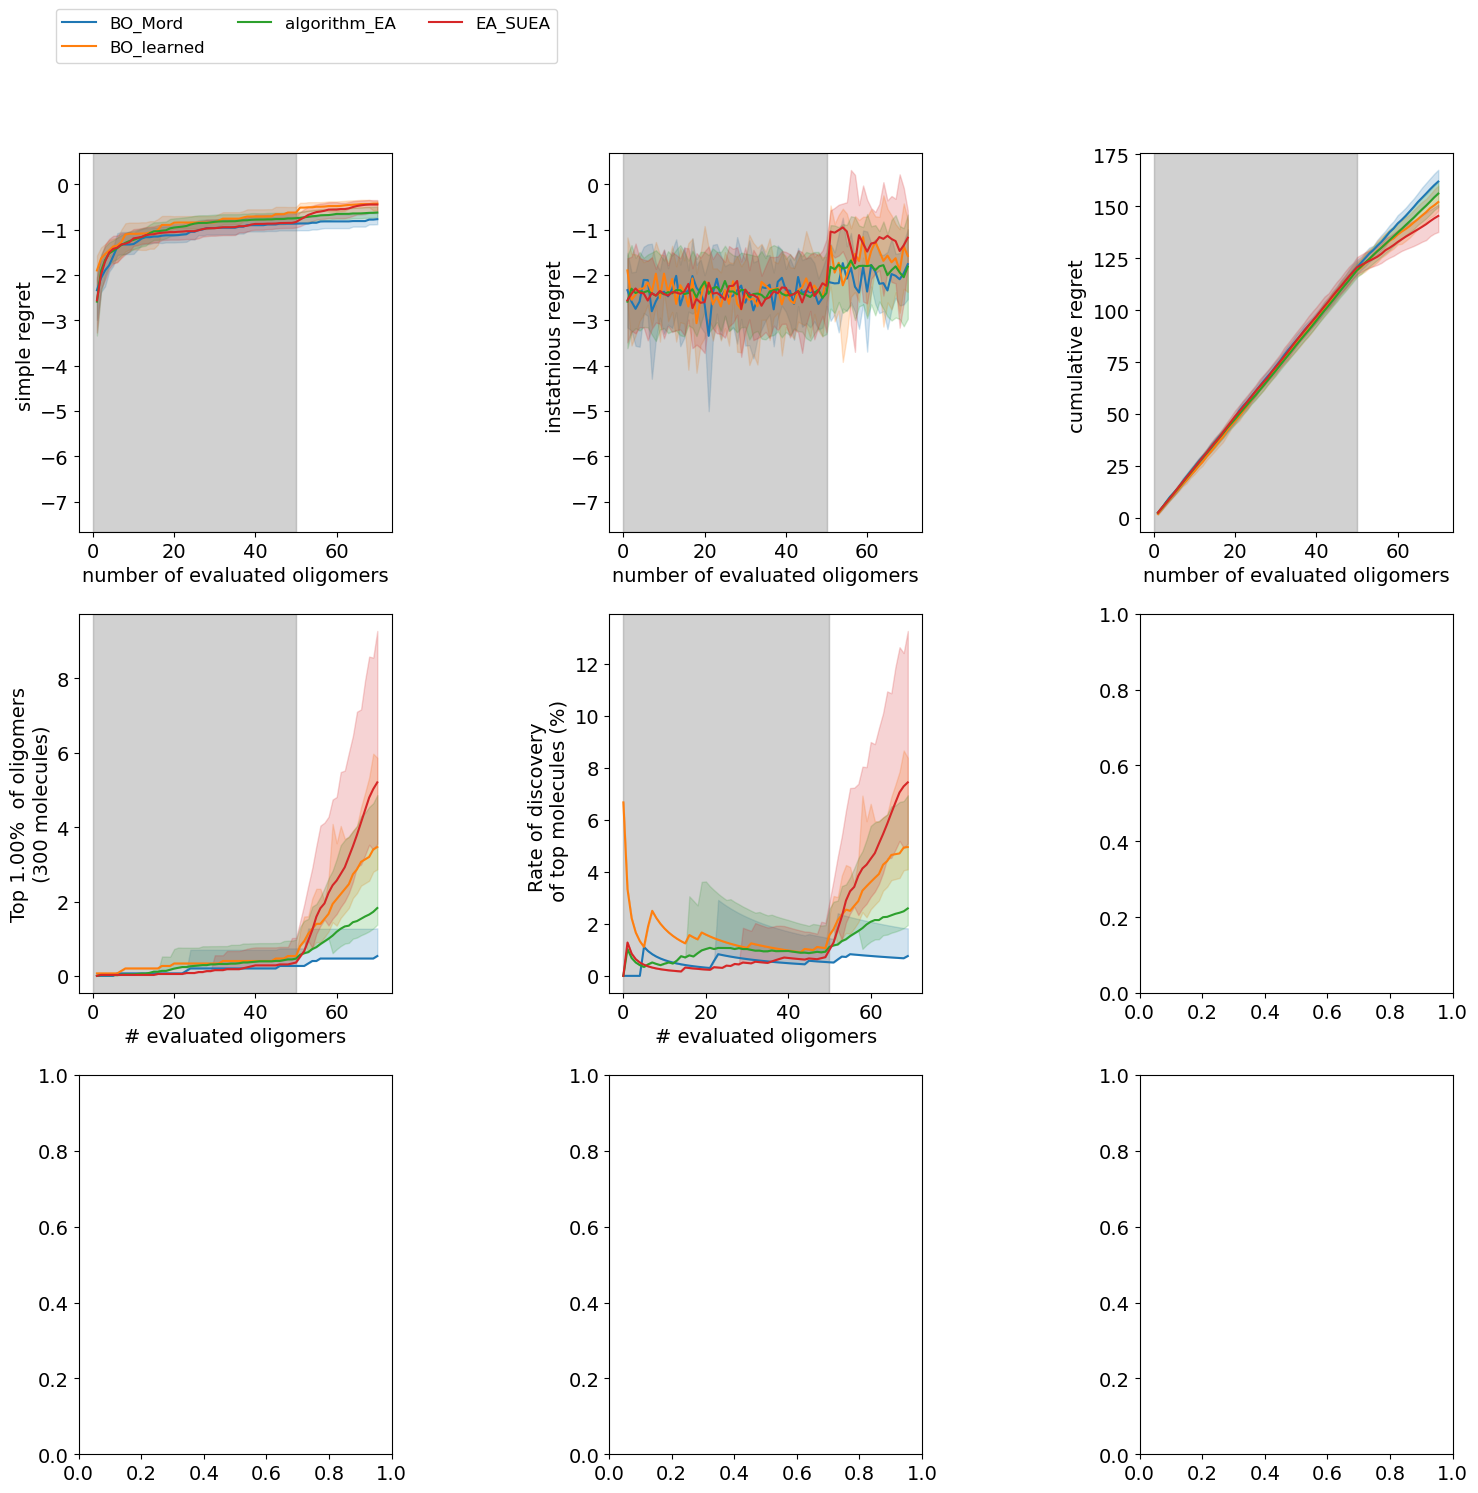

In [15]:
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.loc[[0, 1, 2, 3]]
fig, axes, metric_dict_res = plot_results_all.plot_metric(
    df_plot,
    plot_function_list_single,
    results_dict,
    df_list,
    nb_iterations=min_num_iteration,
)
fig.tight_layout()


20